# Home Credit Default RiskのEDA
当該コンペは、様々なユーザ属性を元にデータ分析を行い、ローン返済できる人・返済出来ない人を予測することです。友正自身初めてのEDAのため、初歩的な確認を含めてEDAを行って行きたいと思います。ホームクレジット社のマイクロファイナンスサービスと関連しているのかもしれないです。銀行口座を持てない人でも、ローンの機会を享受できるようにする、素晴らしい取り組みなのかも。 もっと突っ込んだExplanatory（データ探索）を行いたいのですが、次の課題が進まなくなってしまうため、一旦ここでストップします。どこかで空き時間ができれば再度見直すかもしれません。

以下のサイトをメモとして載せておきます。  
https://www.kaggle.com/osciiart/homecreditrisk-extensive-eda-baseline-model-jp
https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

# ライブラリのインポート
機械学習で必要なライブラリをインポートします。また今回使用するファイルを一覧で表示しておきます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from subprocess import check_output

%matplotlib inline
print(check_output(['ls','/Users/tsuneo/git/20181021/all']).decode('utf8'))

HomeCredit_columns_description.csv
POS_CASH_balance.csv
application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
installments_payments.csv
previous_application.csv
sample_submission.csv



# ファイルの読み込み
csvファイルをpandas.DataFrameとして読み込むには、pandasの関数read_csv()を使います。

In [2]:
original_dir_str = '/Users/tsuneo/git/20181021/all/'
POS_CASH_balance_df = pd.read_csv(original_dir_str + 'POS_CASH_balance.csv')
application_test_df = pd.read_csv(original_dir_str + 'application_test.csv')
application_train_df = pd.read_csv(original_dir_str + 'application_train.csv')
bureau_df = pd.read_csv(original_dir_str + 'bureau.csv')
bureau_balance_df = pd.read_csv(original_dir_str + 'bureau_balance.csv')
credit_card_balance_df = pd.read_csv(original_dir_str + 'credit_card_balance.csv')
installments_payments_df = pd.read_csv(original_dir_str + 'installments_payments.csv')
previous_application_df = pd.read_csv(original_dir_str + 'previous_application.csv')
sample_submission_df = pd.read_csv(original_dir_str + 'sample_submission.csv')

pandasのread_csvメソッドとして読み込んだ場合、どのようなデータ型なのか調べてみた。
pandas.core.frame.DataFrameであることが確認出来た。

In [3]:
#DataFrameとして読み込まれいてることを確認
type(POS_CASH_balance_df)

pandas.core.frame.DataFrame

# 各ファイルのデータ数を把握する

In [4]:
print('POS_CASH_balance_df',"{:,}".format(POS_CASH_balance_df.shape[0]))
print('application_test_df'   ,"{:,}".format(application_test_df.shape[0]))
print('application_train_df'   ,"{:,}".format(application_train_df.shape[0]))
print('bureau_df',"{:,}".format(bureau_df.shape[0]))
print('bureau_balance_df',"{:,}".format(bureau_balance_df.shape[0]))
print('credit_card_balance_df',"{:,}".format(credit_card_balance_df.shape[0]))
print('installments_payments_df',"{:,}".format(installments_payments_df.shape[0]))
print('previous_application_df',"{:,}".format(previous_application_df.shape[0]))
print('sample_submission_df',"{:,}".format(sample_submission_df.shape[0]))

POS_CASH_balance_df 10,001,358
application_test_df 48,744
application_train_df 307,511
bureau_df 1,716,428
bureau_balance_df 27,299,925
credit_card_balance_df 3,840,312
installments_payments_df 13,605,401
previous_application_df 1,670,214
sample_submission_df 48,744


# 各ファイルのデータ数をグラフで確認してみる
もっと綺麗（シンプル）なやり方があると思うが。

<BarContainer object of 9 artists>

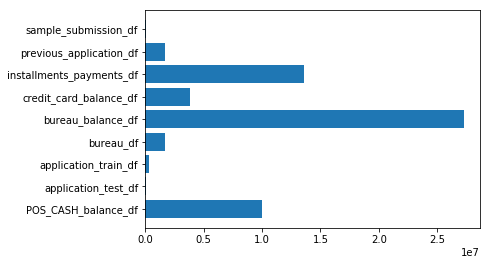

In [5]:
list = [POS_CASH_balance_df.shape[0]]
list.append(application_test_df.shape[0])
list.append(application_train_df.shape[0])
list.append(bureau_df.shape[0])
list.append(bureau_balance_df.shape[0])
list.append(credit_card_balance_df.shape[0])       
list.append(installments_payments_df.shape[0])
list.append(previous_application_df.shape[0])
list.append(sample_submission_df.shape[0])
#print(list)
plt.barh([
         'POS_CASH_balance_df',
         'application_test_df',
         'application_train_df',
         'bureau_df',
         'bureau_balance_df',
         'credit_card_balance_df',
         'installments_payments_df',
         'previous_application_df',
         'sample_submission_df'],list)

上記グラフでは、圧倒的にbureau（ビューロー：事務局、案内所という単語）の残高（balance）版が多い。2,730万件って。。次に多いのが、installments_payments（分割払い）の1,360万件。３位がPOS_CASH_balance


**1位：bureau_balance：**  
クレジットビューローから提供された、過去のクレジットの月間残高。このテーブルには、前回のクレジットについて過去に記録された各クレジットの履歴が1行ずつ表示されます。つまり、ホームクレジット社以外のクレジット会社との取引してた時の月次残高レコードを保持ているファイルということかもしれない。各月で１行レコードが作成されている。つまり、月次トランザクションテーブルのようなものか。

**installments_payments：**  
ホームクレジットの以前に支払われたクレジットの返済履歴  
以前のカード支払いの履歴。１回返済すると１レコードが生成されるイメージのようだ。２４回分割支払いの場合、ちゃんと支払えば２４レコードが生成されるはず。支払い毎に１レコード生成。  

**※クレジットビューロー：個人信用情報機関のこと。**  
クレジットカードは入会の際に審査がありますが、その審査の際にはカード申込者が過去に延滞などネガティブな情報がないかどうかを確認する作業があります。そこで利用されるのが個人信用情報機関。個人信用情報機関は、クレジットカード会社各社が消費者のカード利用や借り入れ状況についての情報を共有し合う目的で設立された機関です。  
https://card.benrista.com/technical-term/5695/

# 今回はtrainファイルのみで行う
初めてということもあり、ベースファイルであるapplication_trainだけに限定してEDAを行うこととする。  
trainファイルの各項目のデータ型を調査してみる。

In [6]:
application_train_df.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

# データ型をグラフで表示しみる
オブジェクト型がある程度含まれていることがわかる

In [7]:
application_train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

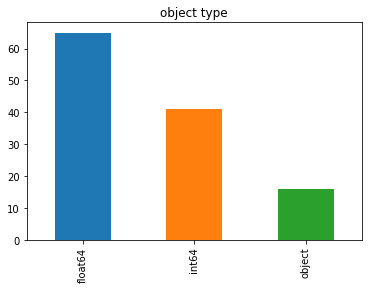

In [8]:
application_train_df.dtypes.value_counts().plot.bar()
plt.title("object type")
plt.show()

# Null値を確認する

In [9]:
application_train_df.isnull().any().any()

True

一個でもNaNがあることが分かった

# 訓練データのターゲット（返済出来なかった人）の割合を確認
目的変数の割合を確認してみる。  
９割が返済出来ている人、１割が返済出来ていない人であることが分かる  
0 : 返済可能（普通な人　○）  
1 : 返済不可能（ダメな人　×）

In [10]:
# application_train_dfの中で、TARGET列で、０、１の件数を確認する。
print(application_train_df['TARGET'].value_counts(),'\n')
print(application_train_df['TARGET'].value_counts(dropna=False))

0    282686
1     24825
Name: TARGET, dtype: int64 

0    282686
1     24825
Name: TARGET, dtype: int64


数字だけ見ても、直感的にイメージ出来ないので、視覚的にわかるように円グラフで描画してみようと思います。  
そこで、必要なライブラリはmatplotlib.pyplot.figureのようです。ここでfigureの解説をします。  
複数のグラフを描く場合figureとaxesという概念が出てきます。figure は図全体、axes はその内部に用意される座標軸です。ただ、今回は１つのグラフなので、figureを使わないくても良いのかも知れません。

In [11]:
temp = application_train_df['TARGET'].value_counts()
print('◼️application_train_dfの型--------：\n',type(application_train_df),'\n')
print('◼️tempの型--------：\n',type(temp),'\n')
print('◼️temp自体の値--------：\n',temp,'\n')
print('◼️temp.sum()の値--------：\n',temp.sum(),'\n')
print('◼️temp / temp.sum()の値--------：\n',temp / temp.sum(),'\n')
sizes = np.array((temp / temp.sum())*100)
print('◼️sizesの値----------：\n',sizes,'\n')
print('◼️sizesの型----------：\n',type(sizes))

◼️application_train_dfの型--------：
 <class 'pandas.core.frame.DataFrame'> 

◼️tempの型--------：
 <class 'pandas.core.series.Series'> 

◼️temp自体の値--------：
 0    282686
1     24825
Name: TARGET, dtype: int64 

◼️temp.sum()の値--------：
 307511 

◼️temp / temp.sum()の値--------：
 0    0.919271
1    0.080729
Name: TARGET, dtype: float64 

◼️sizesの値----------：
 [91.92711805  8.07288195] 

◼️sizesの型----------：
 <class 'numpy.ndarray'>


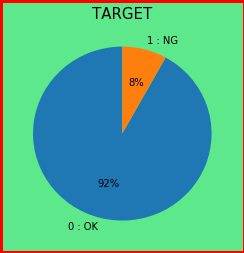

In [12]:
# figureメソッドを初めて使うので、Figureオブジェクトの色をいじってみた
plt.figure(num=1,figsize=(4,4),facecolor=(0.3,0.9,0.5,0.9),edgecolor='red',linewidth=5)

# TARGETの件数を取得してみる
temp = application_train_df['TARGET'].value_counts()

# この値はarray([0,1])
# labels = (np.array(temp.index))
labels = ['0 : OK', '1 : NG']

# tempの型は、pandas.core.series.Seriesです。
sizes = (np.array((temp / temp.sum())*100))

# matplotlib.pyplot.pieメソッドを利用する。第一引数にグラフ要素の値のシーケンス（リスト）を与える。
# autopctは構成割合をパーセンテージで表示する。デフォルトはNone
# フォーマット指定子　%.<小数点以下の桁数>f
# %はフォーマット指定子を指定するためのエスケープ文字
# fは実数を指定するための指定子

plt.pie(sizes, labels=labels, autopct='%.f%%', startangle=90)
plt.title("TARGET", fontsize=15)
plt.show()

# ハウスタイプモードの割合を円グラフで確認
結果から、このデータはblock_of_flatsに偏りが高いのでターゲットを特定する特徴量としては使えないことが分かった

In [13]:
print(application_train_df['HOUSETYPE_MODE'].value_counts(dropna=False),'\n')
print(application_train_df['HOUSETYPE_MODE'].value_counts(),'\n')

print(application_train_df.HOUSETYPE_MODE.value_counts(dropna=False))

NaN                 154297
block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64 

block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64 

NaN                 154297
block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64


Null値も含めて扱いたい場合は、value_countsにdropna=Falseを指定しないとだめ

HOUSETYPE_MODE1: [50.17609126 48.94231426  0.48746224  0.39413224]
HOUSETYPE_MODE2: [98.23057945  0.97837012  0.79105043]


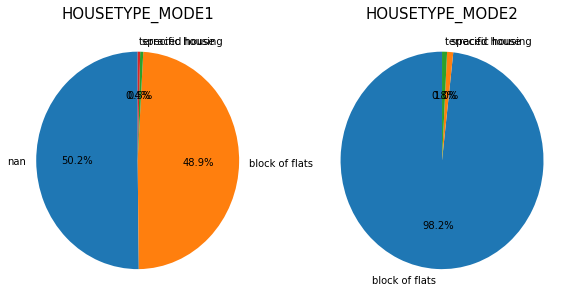

In [14]:
plt.figure(figsize=(10,5))
# 欠損値を除外（削除）するにはdropna()メソッド
temp1 = application_train_df['HOUSETYPE_MODE'].value_counts(dropna=False)
temp2 = application_train_df['HOUSETYPE_MODE'].value_counts()

labels１ = (np.array(temp1.index))
labels2 = (np.array(temp2.index))
#print(type(labels1)) # ちょっと気になったので

sizes１ = (np.array((temp1 / temp1.sum())*100))
sizes2 = (np.array((temp2 / temp2.sum())*100))

print('HOUSETYPE_MODE1:',sizes1)
print('HOUSETYPE_MODE2:',sizes2)

plt.subplot(121)
plt.pie(sizes1, labels=labels1, 
        autopct='%1.1f%%', startangle=90)
plt.title("HOUSETYPE_MODE1", fontsize=15)

plt.subplot(122)
plt.pie(sizes2, labels=labels2, 
        autopct='%1.1f%%', startangle=90)
plt.title("HOUSETYPE_MODE2", fontsize=15)

plt.show()

# 契約タイプを確認する
これを知りたかった理由は、bereauファイルの説明箇所の冒頭で、「全ての今回のサンプルのローン・・」とあり、ローンとクレジットはどのくらいの割合でデータが準備されているかを知りたいためです。  
Cash loans ：現金ローン　（金融業者からユーザにお金が渡される）
Revolving loans　:「回転ローン（反復ローン）」とも呼ばれ、一定の与信枠の範囲内において、自由に反復借入れが可能で、返済については一定のミニマムペイメント（毎月支払う最小返済義務額）でよいというタイプのローンをいいます。


In [15]:
# application_train_dfの中で、契約タイプ列で、それぞれの件数を確認する。
# また、合計値と当該ファイルのレコード数と一致していることを確認。
print(application_train_df['NAME_CONTRACT_TYPE'].value_counts(dropna=False),'\n')
print('レコード数：',application_train_df['NAME_CONTRACT_TYPE'].value_counts().sum())
print('欠損値の確認：',application_train_df['NAME_CONTRACT_TYPE'].isnull().sum())
#print(application_train_df['TARGET'].value_counts(dropna=False))

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64 

レコード数： 307511
欠損値の確認： 0


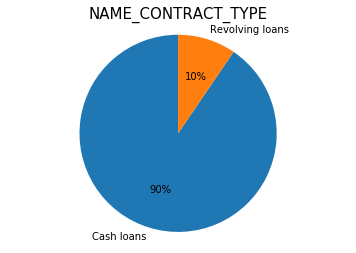

In [16]:
temp = application_train_df['NAME_CONTRACT_TYPE'].value_counts()
sizes = (np.array(temp / temp.sum())) * 100
# print(sizes)
labels = temp.index

# pie関数の第一引数xは、グラフ要素の値のシーケンス（リスト）
plt.pie(sizes, labels=labels, autopct='%.f%%', startangle=90)
plt.title("NAME_CONTRACT_TYPE", fontsize=15)

# x軸とy軸の最小および最大値を設定するaxis()を使って円が潰れないようにします。
# 引数には'equal'を設定すると、x軸とy軸の比率が等しくなるので、結果として真円で表示される。
plt.axis('equal')
plt.show()

# TARGETと、他の項目との相関を調査

★pandas.DataFrameの各列の間の相関係数を算出するにはcorr()メソッドを使う。  
★pandas.DataFrameオブジェクトからcorr()メソッドを呼ぶと、各列の間の相関係数が算出される。  
★corr()メソッドではデータ型がobject（文字列）の列は除外され、数値（int, float）型およびbool型の列の間の相関係数が算出される。

In [17]:
application_train_df.corr()['TARGET'].abs().nlargest(10)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64

以下のやり方でも相関係数を取得できます。

In [18]:
application_train_df.corr()['TARGET'].abs().sort_values(ascending=False)[:10]

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64

この結果から、EXT_SOURCE関連の3つが相関が高いことが分かる

# 相関係数を棒グラフで描画してみる
matplotlib.pyplot.barメソッドで、棒グラフを作成してみる。
横向きの方がみやすい。

In [19]:
cor = application_train_df.corr()['TARGET'].abs().nlargest(10)
x1 = cor.index
print('x:index',x1,'\n')

# 以下は、実行できない。エラーが出る。→TypeError: 'Index' object is not callable
# x2 = cor.index()
# print('x:index',x2)

y1 = cor.values
print('y:index',y1)

x:index Index(['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY'],
      dtype='object') 

y:index [1.         0.1789187  0.16047167 0.15531713 0.07823931 0.06089267
 0.05889901 0.05521848 0.05145717 0.05099446]


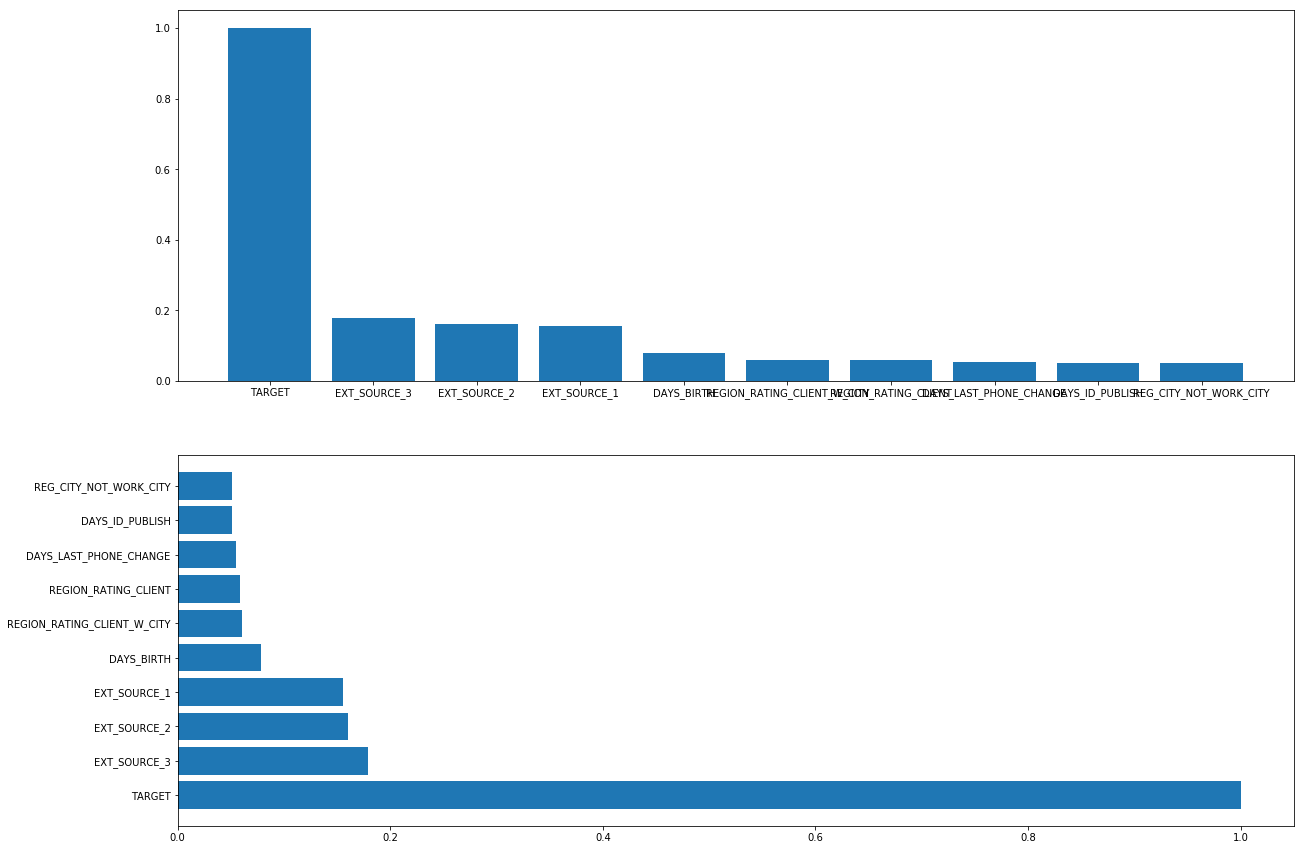

In [20]:
cor = application_train_df.corr()['TARGET'].abs().nlargest(10)
x = cor.index
y = cor.values
#plt.barh(x, y, align='center') # 中央寄せ

plt.figure(figsize=(20,15))

plt.subplot(211)
plt.bar(x, y)
#plt.xticks(x,idx)  # X軸のラベル

plt.subplot(212)
# barhとすれば、横向きのグラフになる
plt.barh(x, y)

plt.show()

# 訓練データのEXT_SOURCEとの多ファイルとの相関を調査
日付や名前などの共通のデータ列を持っている複数のpandas.DataFrameをその列の値に従って結合するにはpandas.merge()関数を使用します。

キーとする列を指定: 引数on, left_on, right_on  
※デフォルトでは2つのpandas.DataFrameに共通する列名の列をキーとして結合処理が行われる。  
※明示的に指定する場合は引数onを使う。省略して問題ない場合も明示しておいたほうが分かりやすい。
※引数left_on, right_onでそれぞれのpandas.DataFrameの列名を別々に指定することも可能。この意味するところは、列名が異なっている場合に使用する。同じであれば、「on」で良い。

結合方法を指定: 引数how  
　・内部結合（inner_join）: how='inner'  
　・左結合（left_join）: how='left'  
　・右結合（right_join）: how='right'  
　・外部結合（outer_join）: how='outer'  
※ 結合方法は引数howに文字列で指定する。デフォルトはhow='inner'。  


In [21]:
# trainファイルを主ファイルとして外部結合しました。紐付けキーはSK_ID_CURRです。
app_t_df_add_bureau = pd.merge(application_train_df, bureau_df, on='SK_ID_CURR', how='left')
app_t_df_add_bureau.shape

(1509345, 138)

データが増大しているが、当然です。bureau_dfのファイルの構造を理解していない状態です。

In [22]:
bureau_df.SK_ID_CURR.unique().shape

(305811,)

In [23]:
app_t_df_add_bureau.corr()['TARGET'].abs().nlargest(10)

TARGET                         1.000000
EXT_SOURCE_3                   0.184104
EXT_SOURCE_1                   0.152659
EXT_SOURCE_2                   0.147898
DAYS_BIRTH                     0.067763
DAYS_CREDIT                    0.061556
REGION_RATING_CLIENT_W_CITY    0.051181
REGION_RATING_CLIENT           0.049232
DAYS_LAST_PHONE_CHANGE         0.043480
DAYS_ID_PUBLISH                0.043160
Name: TARGET, dtype: float64

In [24]:
#ここでやりたかったことは、bureau_dfを'SK_ID_CURR'と'DAYS_CREDIT'でグループbyしたかった。エラーが発生していうまくいかない。
#bureau_df[['SK_ID_CURR','DAYS_CREDIT']].groupby(['SK_ID_CURR','DAYS_CREDIT']).

In [25]:
app_t_df_add_bureau = pd.merge(application_train_df, bureau_df[['SK_ID_CURR','DAYS_CREDIT']], on='SK_ID_CURR', how='left')
app_t_df_add_bureau.shape

(1509345, 123)

In [26]:
#application_train_df_add_bureau.TARGET

### seabornのヒートマップで表示させようとしたら上手くいかない

In [27]:
'''
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(application_train_df.corr()['TARGET'].sort_values()[:30],
            linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
'''

"\ncolormap = plt.cm.magma\nplt.figure(figsize=(16,12))\nplt.title('Pearson correlation of continuous features', y=1.05, size=15)\nsns.heatmap(application_train_df.corr()['TARGET'].sort_values()[:30],\n            linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)\n"

### ヘッダー情報

In [28]:
application_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
POS_CASH_balance_df.sort_values('SK_ID_CURR').head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
8531326,1851984,100001,-94,4.0,0.0,Active,0,0
1891462,1851984,100001,-95,4.0,1.0,Active,7,7
8789081,1369693,100001,-56,4.0,3.0,Active,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0
1261679,1851984,100001,-96,4.0,2.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
9849444,1038818,100002,-15,24.0,20.0,Active,0,0


In [30]:
application_test_df.SK_ID_CURR.sort_values().head()

0    100001
1    100005
2    100013
3    100028
4    100038
Name: SK_ID_CURR, dtype: int64

In [31]:
application_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [33]:
bureau_balance_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [34]:
credit_card_balance_df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [35]:
installments_payments_df.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [36]:
previous_application_df.sort_values('SK_ID_CURR').head(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
935548,1564014,100004,Consumer loans,5357.250,24282.0,20106.0,4860.0,24282.0,FRIDAY,5,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0
1259112,1857999,100005,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,10,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1378978,2495675,100005,Consumer loans,4813.200,44617.5,40153.5,4464.0,44617.5,THURSDAY,11,...,Connectivity,12.0,high,POS mobile with interest,365243.0,-706.0,-376.0,-466.0,-460.0,0.0
900957,1489396,100006,Revolving loans,13500.000,270000.0,270000.0,NaN,270000.0,THURSDAY,15,...,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
1607443,1697039,100006,Cash loans,32696.100,688500.0,906615.0,NaN,688500.0,THURSDAY,15,...,XNA,48.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
sample_submission_df.sort_values('SK_ID_CURR').head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


### めも
sample_submission_dfはkaggleで提出するためのファイル形式

# カラムを全部表示させるための処理

In [38]:
#pd.set_option("display.max_colwidth", 300)
pd.set_option('display.max_columns', 300)
pd.set_option("display.max_rows", 10)
#pd.options.display.width=300
application_train_df.head()
#application_test_df.shape

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [39]:
bureau_df.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [40]:
bureau_balance_df

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


 # CODE_GENDERの中身について確認
 まずは、男性・女性の件数を取得してみる。それ以外の値も存在しているか確認する

In [41]:
# XNAとはなんぞや？
application_train_df.CODE_GENDER.value_counts(dropna=False)

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

データ型確認を確認した。下の結果をみて欲しい。項目を指定した場合は**Series**であり、指定しなかったら**DataFramede**であること！！　ちゃんと覚えて置くように。
このことが分かったので、unique()を使うことになる。つまり、DataFrameではないからnunique()を使わない。

In [42]:
print(type(application_train_df.CODE_GENDER))
print(type(application_train_df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


### ちょっと、ここら辺でちゃんと整理しておこう。一意な要素を求めるメソッドを。
**pandas.Series.value_counts()：**  
ユニークな要素の値がindex、その出現個数がdataとなるpandas.Seriesを返す。要素の頻度（出現回数）が必要な場合はこちらを使う。デフォルトではNaNは除外されるが、引数dropna=FalseとするとNaNもカウントされる。引数normalize=Trueとすると、合計が1になるように規格化した値が返される。

**pandas.Series.unique()**
ユニークな要素の値のリストを返す。list型（Pythonの組み込み型）ではなく一次元のNumPy配列ndarray型。欠損値NaNも含まれる。

**pandas.Series.nunique()**  
ユニークな要素の個数を整数int型で返す。デフォルトではNaNは除外され、引数dropna=FalseとするとNaNも含んだ結果となる。

**pandas.DataFrame.nunique()**  
ユニークな要素の個数を列ごとに算出する。pandas.Series型を返す。デフォルトではNaNは除外され、引数dropna=FalseとするとNaNも含んだ結果となる。また、デフォルトでは列ごとの値だが、引数axis=1またはaxis='columns'とすると行ごとの値を返す。

**ユニークな要素の個数（重複を除いた件数）**
pandas.Series.nunique(), pandas.DataFrame.nunique()によってユニークな要素の個数（重複を除いた件数）をカウントできる。

**ユニークな要素の値のリスト**
unique()ではNumPy配列ndarray型でユニークな要素の値のリストを取得できる。list型（Pythonの組み込み型）が欲しい場合はtolist()メソッドで変換可能。

In [43]:
print(application_train_df.CODE_GENDER.unique())
print(application_train_df['CODE_GENDER'].unique())

['M' 'F' 'XNA']
['M' 'F' 'XNA']


上記の項目（列）の指定の仕方は、どちらでも良さそうだ。どっちが良いのだろう。  
次にやりたいことは、XNAのデータを取り出してみたい。以下のコードで実現できた。

In [44]:
application_train_df[application_train_df.CODE_GENDER == 'XNA']
#application_train_df['CODE_GENDER'] == 'XNA'

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,337500.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.020713,-20232,-10044,-10024.0,-3537,13.0,1,1,1,1,1,0,NaN,2.0,3,3,TUESDAY,10,0,0,0,0,0,0,Business Entity Type 1,NaN,0.295998,0.461482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-286.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,225000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13717,-2797,-2241.0,-4659,NaN,1,1,1,1,1,0,Low-skill Laborers,4.0,2,2,FRIDAY,16,0,0,0,0,0,0,Industry: type 3,NaN,0.709205,0.310818,0.0165,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0233,NaN,0.0115,NaN,0.0000,0.0168,0.0382,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0238,NaN,0.0120,NaN,0.0000,0.0167,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0237,NaN,0.0117,NaN,0.000,NaN,block of flats,0.0090,"Stone, brick",No,0.0,0.0,0.0,0.0,-493.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,225000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.035792,-10647,-1228,-183.0,-1671,NaN,1,1,1,1,1,0,Core staff,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Kindergarten,0.404970,0.659185,0.076984,0.0773,0.1353,0.9921,0.8912,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0630,0.0621,0.0000,NaN,0.0788,0.1404,0.9921,0.8955,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0689,0.0647,0.0000,NaN,0.0781,0.1353,0.9921,0.8927,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0641,0.0632,0.0000,NaN,reg oper spec account,block of flats,0.076

男性女性をグラフ表示させてみた。だいぶ円グラフ表示には慣れてきた。  
女性65%、男性35%か。ちょっと偏っている気がする。女性の方が融資受けられない貧困層が多いって事かなぁ〜。。

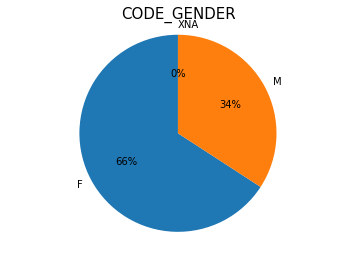

In [45]:
temp = application_train_df['CODE_GENDER'].value_counts()
calc = np.array(temp / temp.sum()) * 100
labels = temp.index
plt.pie(calc, labels=labels, autopct='%.f%%', startangle=90)
plt.title("CODE_GENDER", fontsize=15)

plt.axis('equal')
plt.show()

以下では、SK_ID_CURR項目が、訓練データの中で重複していないことが確認できた。

In [46]:
application_train_df.groupby('SK_ID_CURR').sum().shape

(307511, 105)

In [47]:
application_train_df.SK_ID_CURR.nunique()

307511

In [48]:
application_train_df.shape

(307511, 122)

## とにかくいじってみた
POS_CASH_balance_dfのSK_ID_CURR

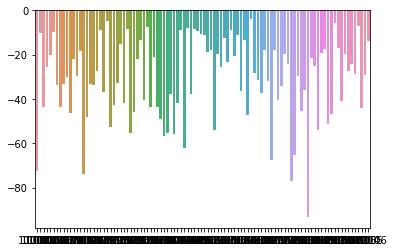

In [49]:
cnt = POS_CASH_balance_df.groupby("SK_ID_CURR")["MONTHS_BALANCE"].aggregate(np.mean).reset_index()
a = cnt.SK_ID_CURR.values[0:100]
b = cnt.MONTHS_BALANCE.values[0:100]
#print(cnt.index)
#print(cnt.values)
#plt.figure(figsize=(12,9))
sns.barplot(a,b)
#sns.barplot(cnt.index, cnt.values, alpha=0.8)
#plt.show()

In [50]:
# # application_train_df.CODE_GENDER.groupby(CODE_GENDER)